# Small data and deep learning
This mini-project proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should not exceed 2MB. Please name your notebook (LASTNAME)\_(FIRSTNAME).ipynb, zip/tar it with any necessary files required to run your notebook, in a compressed file named (LASTNAME)\_(FIRSTNAME).X where X is the corresponding extension. Zip/tar files exceeding 2MB will not be considered for grading. Submit the compressed file via the submission link provided on the website of the class.__

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

In [1]:
import torch
from torchvision.datasets.cifar import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data.sampler import Sampler
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_224 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root='./data', train=True, download=True , transform = transform) 
testset = CIFAR10(root='./data', train=False, download=True , transform = transform)

class SubsetSampler(Sampler):
    def __init__(self, number):
        self.number = number

    def __iter__(self):
        return iter(torch.arange(self.number))

    def __len__(self):
        return self.number

sampler_100 = SubsetSampler(100)

trainloader = DataLoader(trainset, batch_size=10, sampler = sampler_100, shuffle=False)
trainevalloader = DataLoader(trainset, batch_size=100, sampler = sampler_100, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

The evaluation of the training procedure is difficult because of the small amount of labeled set we have. This is problematic because we don't have enough observations to estimate properly the quality of the convergence of the algorithm or to estimate the gradients during the training procedure. Also, the small amount of data can cause the algorithm to overfit very easily.

Some solutions to this problem can be to use strong regularization (Through weights regularization and Dropouts for example) and to use weak supervision algorithms that can use unlabeled data to improve the model and have a better idea of te training. Also, a good way to evaluate the training would be to have access to a test set ( or a way to test the performances of the trained model) to have a good idea of the performance of the model. This is our case since we can use a test set.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performances with reported number from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context, as those researchers had access to GPUs.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
    
def train_loop(epochs , trainloader , testloader , trainevalloader , optimizer , net , criterion , verbose):
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
        if epoch % verbose == verbose - 1 : 
            print('[Epoch %d] loss: %.3f' % (epoch + 1, running_loss / 100))
            
            
    print('Training Finished')
    
    
    with torch.no_grad():
        
        print('Results on train set :')

        _, predicted = torch.max( net(list(trainevalloader)[0][0]) , 1)
        correct = torch.sum(predicted == list(trainevalloader)[0][1])
        total = 100
        print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))



        print('Results on test set :')

        predictions , true_labs = [] , []

        for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data

            # forward + backward + optimize
            outputs = net(inputs)
            _, predicted = torch.max( outputs , 1)
            predictions = predictions + list(predicted)
            true_labs = true_labs + list(labels)


        correct = torch.sum(torch.tensor(predictions) == torch.tensor(true_labs))
        total = 10000
        print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
        

In [29]:
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_loop(40 , trainloader , testloader , trainevalloader , optimizer , cnn , criterion , 10)

[Epoch 10] loss: 0.159
[Epoch 20] loss: 0.010
[Epoch 30] loss: 0.007
[Epoch 40] loss: 0.012
Training Finished
Results on train set :
Accuracy of the network on the train images: 98 %
Results on test set :
Accuracy of the network on the test images: 18 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   CNN  | 100 | 100% |21%|

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). If possible, please report the accuracy obtained on the whole dataset, as well as the reference paper/GitHub link you might have used.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (~5 minutes).

In [4]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained = False)
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.CrossEntropyLoss()

trainset = CIFAR10(root='./data', train=True, download=True , transform = transform_224) 
testset = CIFAR10(root='./data', train=False, download=True , transform = transform_224)
sampler_100 = SubsetSampler(100)

trainloader = DataLoader(trainset, batch_size=10, sampler = sampler_100, shuffle=False)
trainevalloader = DataLoader(trainset, batch_size=100, sampler = sampler_100, shuffle=False)
testloader = DataLoader(testset, batch_size=10, shuffle=False)

train_loop(10 , trainloader , testloader  , trainevalloader , optimizer , resnet18 , criterion , 10)

Files already downloaded and verified
Files already downloaded and verified
[Epoch 10] loss: 0.051
Training Finished
Results on train set :
Accuracy of the network on the train images: 75 %
Results on test set :
Accuracy of the network on the test images: 18 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Resnet18  | 10 | 75% | 18% |

## VGG-like architectures

__Question 4:__ Same question as before, but with a *VGG*. Which model do you recommend?

In [4]:
import torchvision.models as models
vgg11 = models.vgg11(pretrained = False)

optimizer = optim.SGD(vgg11.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_loop(10 , trainloader , testloader,  trainevalloader , optimizer , vgg11 , criterion , 10)

[Epoch 10] loss: 0.248
Training Finished
Results on train set :
Accuracy of the network on the train images: 17 %
Results on test set :
Accuracy of the network on the test images: 10 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   VGG11  | 10 | 17% | 10% |

Based on these results, the best choice appears to be the Resnet Architechture, although the VGG architechture shoud be trained more (the training & evaluation time makes it difficult on the current setup.)

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 5:__ Pick a model from the list above, adapt it to CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [6]:
model = models.resnet18(pretrained = True)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for param in model.parameters():
    param.require_grad = False
    
model.fc = nn.Linear(512, 10)

train_loop(10 , trainloader , testloader , trainevalloader , optimizer , model , criterion , 10)

[Epoch 10] loss: 0.002
Training Finished
Results on train set :
Accuracy of the network on the train images: 100 %
Results on test set :
Accuracy of the network on the test images: 35 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|  Pretrained Resnet18  | 10 | 100% | 35% |

## DCGan features

GANs correspond to an unsupervised technique for generating images. In https://arxiv.org/pdf/1511.06434.pdf, Sec. 5.1 shows that the representation obtained from the Discriminator has some nice generalization properties on CIFAR10.

__Question 6:__  Using for instance a pretrained model from https://github.com/soumith/dcgan.torch combined with https://github.com/pytorch/examples/tree/master/dcgan, propose a model to train on $\mathcal{X}_{\text{train}}$. Train it and report its accuracy.

*Hint:* You can use the library: https://github.com/bshillingford/python-torchfile to load the weights of a model from torch(Lua) to pytorch(python).

In [18]:
#This part was run under Python 2.7
# !wget https://drive.google.com/open?id=1wz0Ke0TL8J9x2AkfpYTBII0UfO_OPVgH

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchfile

class DiscriminatorFeatures(nn.Module):
    def __init__(self, nc, ndf):
        super(DiscriminatorFeatures, self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 0, bias=False),
            )
        
    def forward(self, input):

        output = self.main(input)
        return output.view(-1, 320)

def load_feature_extractor():
    path = "landscapes_776_net_D_cpu.t7"
    lua_weights = torchfile.load(path)
    feature_extractor = DiscriminatorFeatures(3, 40)
    
    feature_extractor.main._modules['0'].weight.data = torch.FloatTensor(lua_weights[b'modules'][0][b'weight'])
    feature_extractor.main._modules['2'].weight.data = torch.FloatTensor(lua_weights[b'modules'][2][b'weight'])
    feature_extractor.main._modules['3'].weight.data = torch.FloatTensor(lua_weights[b'modules'][3][b'weight'])
    feature_extractor.main._modules['5'].weight.data = torch.FloatTensor(lua_weights[b'modules'][5][b'weight'])
    feature_extractor.main._modules['6'].weight.data = torch.FloatTensor(lua_weights[b'modules'][6][b'weight'])
    feature_extractor.main._modules['8'].weight.data = torch.FloatTensor(lua_weights[b'modules'][8][b'weight'])
    
    return feature_extractor

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.feature_extractor = load_feature_extractor()
        self.fc = nn.Linear(320, 10)
        
    def forward(self, input):
        h = self.feature_extractor(input)
        return self.fc(h)

    
model = Classifier()

for param in model.feature_extractor.parameters():
    param.require_grad = False

In [14]:
trainset = CIFAR10(root='./data', train=True, download=True , transform = transform) 
testset = CIFAR10(root='./data', train=False, download=True , transform = transform)
trainloader = DataLoader(trainset, batch_size=10, sampler = sampler_100, shuffle=False)
trainevalloader = DataLoader(trainset, batch_size=100, sampler = sampler_100, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loop(50 , trainloader , testloader, trainevalloader , optimizer , model , criterion , 10)

[Epoch 10] loss: 0.043
[Epoch 20] loss: 0.000
[Epoch 30] loss: 0.000
[Epoch 40] loss: 0.000
[Epoch 50] loss: 0.000
Training Finished
Results on train set :
Accuracy of the network on the train images: 100 %
Results on test set :
Accuracy of the network on the test images: 21 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|  DCGAN Features  | 10 | 100% | 21% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 7:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

## Data augmentations

__Question 8:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ and __Question 4__ with them and report the accuracies.

In [23]:
train_transforms = transforms.Compose([
    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(15, translate=(.2 , .2), 
                               scale= (.7 , 1.3) , shear= 15, resample=False, fillcolor=0),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


trainset = CIFAR10(root='./data', train=True, download=True , transform = train_transforms) 
trainevalset = CIFAR10(root='./data', train=True, download=True , transform = transform_224)
testset = CIFAR10(root='./data', train=False, download=True , transform = transform_224)

sampler_100 = SubsetSampler(100)

trainloader = DataLoader(trainset, batch_size=10, sampler = sampler_100, shuffle=False)
trainevalloader = DataLoader(trainevalset, batch_size=100, sampler = sampler_100, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)


resnet18 = models.resnet18(pretrained = False)
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
train_loop(10 , trainloader , testloader,trainevalloader, optimizer , resnet18 , criterion , 10)

vgg11 = models.vgg11(pretrained = False)
optimizer = optim.SGD(vgg11.parameters(), lr=0.01, momentum=0.9)
train_loop(10 , trainloader , testloader, trainevalloader, optimizer , vgg11 , criterion , 10)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Epoch 10] loss: 0.173
Training Finished
Results on train set :
Accuracy of the network on the train images: 42 %
Results on test set :
Accuracy of the network on the test images: 18 %
[Epoch 10] loss: 0.254
Training Finished
Results on train set :
Accuracy of the network on the train images: 11 %
Results on test set :
Accuracy of the network on the test images: 10 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|  Resnet 18 | 10 | 42% | 18% |
|  VGG 11  | 10 | 11% | 10% |

## Wavelets

__Question 9:__ Use a Scattering Transform as an input to a ResNet-like architecture. You can find a baseline here: https://arxiv.org/pdf/1703.08961.pdf.

*Hint:* You can use the following package: https://www.kymat.io/

In [14]:
# from https://www.kymat.io/gallery_2d/cifar_resnet.html#sphx-glr-gallery-2d-cifar-resnet-py


from kymatio import Scattering2D
import kymatio.datasets as scattering_datasets


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Scattering2dResNet(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10):
        super(Scattering2dResNet, self).__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k
        self.K = in_channels
        self.init_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels, eps=1e-5, affine=False),
            nn.Conv2d(in_channels, self.ichannels,
                  kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.ichannels),
            nn.ReLU(True)
        )

        self.layer2 = self._make_layer(BasicBlock, 32 * k, n)
        self.layer3 = self._make_layer(BasicBlock, 64 * k, n)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc = nn.Linear(64 * k * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), self.K, 8, 8)
        x = self.init_conv(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [16]:
from kymatio import Scattering2D

scattering = Scattering2D(J=2, shape=(32, 32))

scat_transform = transforms.Compose([transforms.ToTensor(),
     scattering])

trainset = CIFAR10(root='./data', train=True, download=True , transform = scat_transform) 
testset = CIFAR10(root='./data', train=False, download=True , transform = scat_transform)


sampler_100 = SubsetSampler(100)

trainloader = DataLoader(trainset, batch_size=10, sampler = sampler_100, shuffle=False)
trainevalloader = DataLoader(trainset, batch_size=100, sampler = sampler_100, shuffle=False)
testloader = DataLoader(testset, batch_size=10, shuffle=False)

resnet = Scattering2dResNet(in_channels = 81*3)
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_loop(10 , trainloader , testloader , trainevalloader , optimizer , resnet , criterion , 10)

Files already downloaded and verified
Files already downloaded and verified
[Epoch 10] loss: 0.034
Training Finished
Results on train set :
Accuracy of the network on the train images: 85 %
Results on test set :
Accuracy of the network on the test images: 19 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|  Scattering Resnet  | 10 | 85% | 19% |

# Weak supervision

Weakly supervised techniques permit to tackle the issue of labeled data. An introduction to those techniques can be found here: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html.

__(Open) Question 10:__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

# Conclusions

__Question 11:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

Through this Homework, we tested several technics to compensate the lack of labeled training data.

The first idea was to simply train a model from scratch, and compare its performance with the performance in the litterature. To achieve that, we trained three classical models: A basic Convolutional neural network, a VGG Architechture and a Resnet Architechture. The pros of this method is that we don't need any external ressources during the training. However, the lack of data makes it very hard to obtain acceptable performances. But we can see that the used architechture can help improve performances, like with the Resnet Architechture. 

The second idea was to use Transfer Learning technics. We could see that using pre-trained weights helped the model to achieve better performances (35% with a pre-trained Resnet 18). However, we couldn't achieve comparable performances by using the features extracted by the Discriminator af a DCGAN Architechture. This technic has its limits since it depends on the generalization of the original dataset and the aaptability of the problem. 

The third idea was to incorpore a priori, or to use other knowledge that we have on our data. We did that through transformation on the data. But we coud see that it didn't improve the results by much. However, it acted as a regularization of the training, which mean that we may achiev better performances by training more the models (Which wasn't done due to lack of performances).

We can see here the performances of each technic:



Populating the interactive namespace from numpy and matplotlib


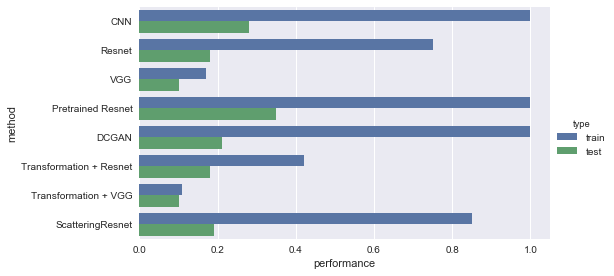

In [29]:
%pylab inline
import pandas as pd 
import seaborn as sns
sns.set()

df = pd.DataFrame()

methods = ['CNN' , 'Resnet' , 'VGG' , 'Pretrained Resnet' , 'DCGAN' , 'Transformation + Resnet' , 
           'Transformation + VGG' , 'ScatteringResnet']

train_performance = [1 , .75 , .17 , 1 , 1 , .42 , .11 , .85]
test_performance = [.28 , .18 , .1 , .35 , .21 , .18 , .10 , .19]

df['method'] = methods + methods
df['type'] = ['train']*len(methods) + ['test']*len(methods)
df['performance'] = train_performance + test_performance

sns.factorplot(y='method', x='performance', hue='type', data=df, kind='bar' , size = 4 , aspect = 2)
plt.show()

To improve our results, we can combine all these technics into a single one. We can also use weak supervision technics to improve the results.